In [1]:
%pip install -Uqq llama-index l402

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from llama_index.core.agent import FunctionCallingAgentWorker, AgentRunner
from llama_index.llms.openai import OpenAI
import httpx
from llama_index.core.tools import FunctionTool

from IPython.display import display, Image

import os
import subprocess


## AI Agent accessing Paywalled Content

In this notebook to create an LLM agent that can search for files in the fewsats platform and pay for them through the 

We will try to search & download this paywalled image:

* https://marketplace.fewsats.com/file/b0dfa667-bafe-4648-a371-b94c8a87da65



First we define the download & search tools. llama_index uses function comments to understand how to use the tools.

In [3]:
async def download_file(file_url: str) -> str:
    """
    Download a file using the requests module.
    
    Args:
    file_url (str): The URL from which to download the file.
    
    Returns:
    str: The path to the downloaded file.
    """
    async with httpx.AsyncClient() as client:
        response = await client.get(file_url)
        response.raise_for_status()  
        
        filename = response.headers.get('file-name')
        with open(filename, 'wb') as f:
            f.write(response.content)

        return filename
    
def search_file() -> str:
    """
    Search for files using the fewsatscli storage search command.
    
    Returns:
    dict: The search results as a dictionary.
    """
    result = subprocess.run(
        ['fewsatscli', 'storage', 'search'],
        capture_output=True, text=True
    )
    return result.stdout



In [4]:
# Create a search tool for the fewsats platform.
search_tool = FunctionTool.from_defaults(
    name="search_tool",
    fn=search_file,
    description="Searches for files in the fewsats platform."
)
# Create download tool using the basic httpx package
download_tool = FunctionTool.from_defaults(
    download_file,
    name="download_tool",
    async_fn=download_file,
    description="Downloads a file from a given URL.",
    return_direct=True,
)

In [5]:
# Setup the LLM and agent
model = "gpt-4-turbo-2024-04-09"
llm = OpenAI(model=model, temperature=0)
agent_worker = FunctionCallingAgentWorker.from_tools(
    [search_tool, download_tool], # <- pass the tools to the agent
    llm=llm, 
    verbose=True
)

agent = AgentRunner(agent_worker)

## Initial Download Attempt

We will ask the agent to search for a watercolor painting in the Fewsats platform. You can see the target file in the Fewsats Marketplace [here](https://marketplace.fewsats.com/file/b0dfa667-bafe-4648-a371-b94c8a87da65).

We expect the agent to search for this file and attempt to download it. However, the data is paywalled so we'll get a 402.



In [6]:
query = """
I want to get a watercolor painting. 
Search if there are any relevant documents and download them. Think step by step.
"""

response = await agent.aquery(query)

Added user message to memory: 
I want to get a watercolor painting. 
Search if there are any relevant documents and download them. Think step by step.

=== Calling Function ===
Calling function: search_tool with args: {}
=== Function Output ===
{
  "files": [
    {
      "external_id": "fd1b0650-845f-466c-b361-cf205bf9fd27",
      "name": "LNNode",
      "description": "ssss",
      "l402_url": "https://api.fewsats.com/v0/storage/download/fd1b0650-845f-466c-b361-cf205bf9fd27",
      "size": 0,
      "extension": "",
      "mime_type": "",
      "cover_url": "https://fewsats-production-public-files.s3.us-west-1.amazonaws.com/cover-images/fd1b0650-845f-466c-b361-cf205bf9fd27",
      "price_in_cents": 100,
      "created_at": "2024-06-10T13:38:09.913183Z",
      "updated_at": "2024-06-10T13:38:09.913183Z",
      "tags": [
        ""
      ]
    },
    {
      "external_id": "ac8237b5-fbb0-42df-bf78-38dc2f1764fc",
      "name": "Deesis",
      "description": "\"Deesis\". XVI ",
      "l402

We can see that the agent tried to donwload the file but it got an `HTTP 402 Payment Required` error.

If you try to visit the link in your browser or curl it you will also get the 402 error:

https://api.fewsats.com/v0/storage/download/23666cec-8a35-45cc-a2ab-b6d857bb9a82

In [7]:
!curl https://api.fewsats.com/v0/storage/download/23666cec-8a35-45cc-a2ab-b6d857bb9a82

{"error":"Payment Required"}

## Setting up L402 for Seamless Payments

We're using a drop-in replacement for `httpx` that makes paid API calls as frictionless as free ones.

Under the hood, it's using the L402 protocol and it needs:
1. An image provider to pay for the content
2. (Optional) A service to store the credentials for future reuse.

In this demo we use Alby as the image provider and a Sqlite service that will store our credentials locally.


In [8]:
from l402.client import httpx # <- Drop-in L402 replacement for httpx
from l402.client.preimage_provider import AlbyAPI
from l402.client.credentials import SqliteCredentialsService

preimage_provider = AlbyAPI(os.getenv('ALBY_TOKEN')) 
credentials_service = SqliteCredentialsService()

httpx.configure(
    preimage_provider=preimage_provider,
    credentials_service=credentials_service
)

Given that httpx is a drop-in replacement for the `httpx` package, we don't even need to modify the download tool as it will pick up `l402 httpx` client directly.


In [9]:
query = """
I want to get a watercolor painting. 
Search if there are any relevant documents and download them. Think step by step.
"""

response = await agent.aquery(query)

Added user message to memory: 
I want to get a watercolor painting. 
Search if there are any relevant documents and download them. Think step by step.

=== Calling Function ===
Calling function: search_tool with args: {}
=== Calling Function ===
Calling function: download_tool with args: {"file_url": "https://example.com/watercolor_painting.pdf"}
=== Function Output ===
{
  "files": [
    {
      "external_id": "fd1b0650-845f-466c-b361-cf205bf9fd27",
      "name": "LNNode",
      "description": "ssss",
      "l402_url": "https://api.fewsats.com/v0/storage/download/fd1b0650-845f-466c-b361-cf205bf9fd27",
      "size": 0,
      "extension": "",
      "mime_type": "",
      "cover_url": "https://fewsats-production-public-files.s3.us-west-1.amazonaws.com/cover-images/fd1b0650-845f-466c-b361-cf205bf9fd27",
      "price_in_cents": 100,
      "created_at": "2024-06-10T13:38:09.913183Z",
      "updated_at": "2024-06-10T13:38:09.913183Z",
      "tags": [
        ""
      ]
    },
    {
      "ex

In [10]:
# the response should contain the path to the download file
print(response)

albero-bello.jpg


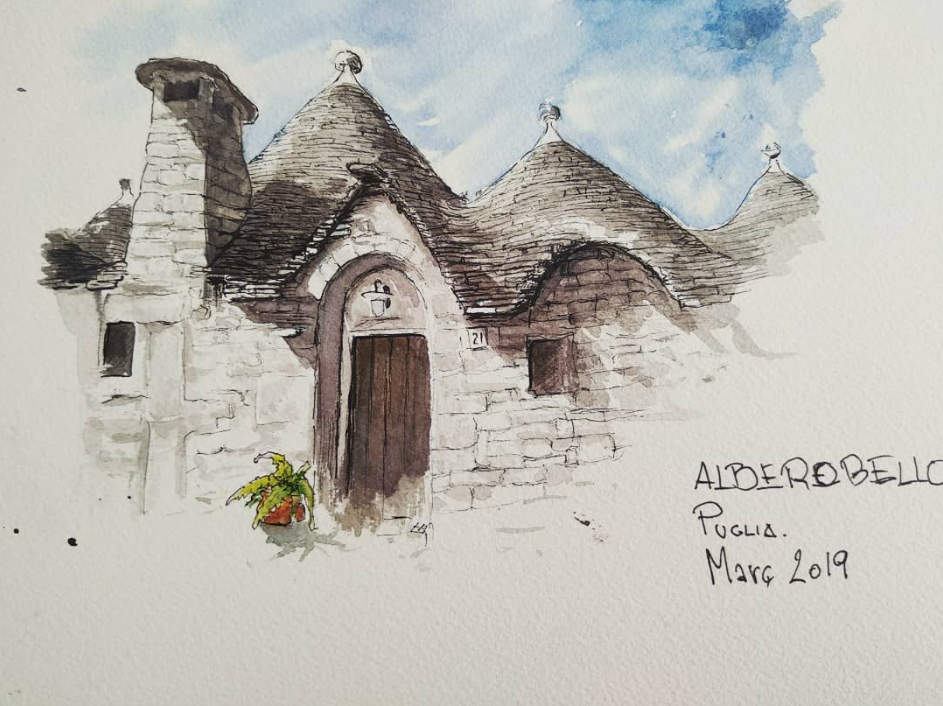

In [11]:
display(Image(response.response))